# Actor-Critic in TensorFlow

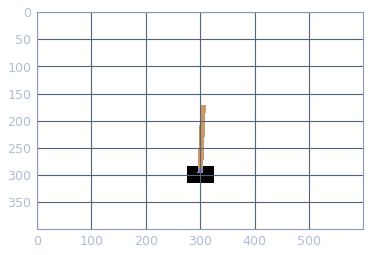

In [1]:
import gym
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")


env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [2]:
class PolicyValueApproximator(Model):
    def __init__(self, action_dim):
        super().__init__()
        self.d1 = Dense(32, activation='relu', name='dense1')
        self.d2 = Dense(16, activation='relu', name='dense2')
        self.d3_policy = Dense(2, activation='relu', name='dense_policy')
        self.d3_value = Dense(1, activation='linear', name='dense_value')

    def __call__(self, x):
        x = self.d1(x)
        x = self.d2(x)
        policy = self.d3_policy(x)
        value = self.d3_value(x)
        return [value, policy]
        
    def model(self):
        x = Input(shape=(4,))
        return Model(inputs=x, outputs=self(x))

In [3]:
tf.keras.backend.clear_session()
policy_value_approximator = PolicyValueApproximator(action_dim=n_actions)

# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()
policy_value_approximator.model().summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
dense1 (Dense)                  (None, 32)           160         input_1[0][0]                    
__________________________________________________________________________________________________
dense2 (Dense)                  (None, 16)           528         dense1[0][0]                     
__________________________________________________________________________________________________
dense_value (Dense)             (None, 1)            17          dense2[0][0]                     
______________________________________________________________________________________________

In [11]:
def policy(states):
    return tf.nn.softmax(policy_value_approximator(states)[1])

def log_policy(states):
    return tf.nn.log_softmax(policy_value_approximator(states)[1])

def get_action_probs(states):
    log_action_probs = tf.squeeze(log_policy(states), 0)
    action_probs = tf.squeeze(policy(states), 0)
   # log_action_probs = log_policy(states)
   # action_probs = policy(states)
    return log_action_probs, action_probs

def compute_entropy(action_probs, log_action_probs):
    return - tf.math.reduce_sum(tf.math.multiply(action_probs, log_action_probs))

def compute_policy_objective(log_action_probs, actions, advantage):
    log_action_taken_probs = log_action_probs[actions]
    J = tf.math.reduce_mean(tf.math.multiply(log_action_taken_probs, advantage))
    return J    

def compute_policy_objective_batch(log_action_probs, actions, advantage):
    log_action_taken_probs = tf.gather_nd(log_action_probs, tf.stack([tf.range(log_action_probs.shape[0]), actions], axis=1))
    J = tf.math.reduce_mean(tf.math.multiply(log_action_taken_probs, advantage))
    return J


In [25]:
def train_step(state_previous, state, action, reward, I, gamma=0.99, entropy_coef=1e-2):
    
    # Environment step
    
    # Gradient descent step  
    with tf.GradientTape(persistent=True) as tape:
        s_prev = tf.Variable(state_previous, dtype='float32', name='state_prev')
        s = tf.Variable(state, dtype='float32', name='state')
        a = tf.Variable(action, dtype='int32', name='action')
        r = tf.Variable(reward, dtype='float32', name='reward')
        
        # Get policy and value functions
        v_s, p_s = policy_value_approximator(s)
    #    print("V(s) is" + str(v_s))
        
        # Get value function for the previous state
        v_s_prev = policy_value_approximator(s_prev)[0]
        
        # Compute action probs
        log_action_probs, action_probs = get_action_probs(s)
        
        # Compute entropy
        entropy = compute_entropy(log_action_probs, action_probs)
        
        # Compute Bellman error
        delta = r + gamma * v_s - v_s_prev
        
        # Compute policy objective
        J = compute_policy_objective(log_action_probs, a, delta)
        policy_loss = -J - entropy_coef * entropy
        
        # Compute MSVE 
        MSVE = 0.5 * tf.math.square(delta)
    
    # Optimise the net and the policy output weights
    gradients_policy = tape.gradient(policy_loss, policy_value_approximator.trainable_variables[:6])
   # for i, gradient in enumerate(gradients_policy):
   #     gradients_policy[i] = tf.math.multiply(gradient, np.squeeze(delta.numpy())) * I
    optimizer.apply_gradients(zip(gradients_policy, policy_value_approximator.trainable_variables[:6]))      

    # Optimise the net and the policy output weights
    train_params_value = np.asarray(policy_value_approximator.trainable_variables)[[0, 1 , 2, 3, 6, 7]].tolist()
    gradients_value = tape.gradient(MSVE, train_params_value)
   # for i, gradient in enumerate(gradients_value):
   #     gradients_value[i] = tf.math.multiply(gradient, np.squeeze(delta.numpy()))
    optimizer.apply_gradients(zip(gradients_value, train_params_value))
    
    return J.numpy().tolist(), entropy.numpy().tolist(), delta.numpy().tolist()


In [31]:
def generate_session(t_max=1000):
    
    # arrays to record session
    states, actions, rewards, J, entropy, delta = np.asarray([], dtype='float32'), [], [], [], [], []

    s_prev = env.reset().astype('float32')
    gamma = 0.99
    I = 1
    
    for t in range(t_max):
        
        # action probabilities and log probabilities
        log_action_probs, action_probs = get_action_probs(np.reshape(s_prev, (1, 4)))
        log_action_probs = log_action_probs.numpy().reshape(2,)
        action_probs = action_probs.numpy().reshape(2,)
        # choose an action
        a = np.random.choice([0, 1], p=action_probs)
        # perform a step
        s, r, done, info = env.step(a)
        
        # perform a train step
        J_tmp, entropy_tmp, delta_tmp = train_step(state_previous=np.reshape(s_prev, (1, 4)), state=np.reshape(s, (1, 4)), action=a, reward=r, I=I)
        
        # record session history to train later
        states = np.concatenate((states, s), axis=0)
        actions.append(a)
        rewards.append(r)
        J.append(J_tmp)
        entropy.append(entropy_tmp)
        delta.append(delta_tmp)

        s_prev = s.astype('float32')
        I = I * gamma
        
        if done:
            break
            
    return states.reshape(-1, s.shape[0]), actions, np.sum(rewards), J, entropy, delta
    

In [32]:
tf.keras.backend.clear_session()
policy_value_approximator = PolicyValueApproximator(action_dim=n_actions)

# Your code: define optimizers
optimizer = tf.keras.optimizers.Adam()

In [33]:
global_rewards = []
global_J = []
global_entropy = []
global_delta = []

for i in range(10000):

    _, _, rewards, J, entropy, delta = generate_session() # generate new sessions
    global_rewards.append(rewards)
    global_J.append(J)
    global_entropy.append(entropy)
    global_delta.append(delta)
    
    if i % 100 == 0:
        print("Episode number {} and the reward is {}".format(i, np.mean(global_rewards[-100:])))
    
    if np.mean(global_rewards[-100:]) > 300:
        print("You Win!")
        break

Episode number 0 and the reward is 38.0
Episode number 100 and the reward is 22.26
Episode number 200 and the reward is 26.19
Episode number 300 and the reward is 27.67
Episode number 400 and the reward is 32.87
Episode number 500 and the reward is 36.01
Episode number 600 and the reward is 44.17
Episode number 700 and the reward is 30.81
Episode number 800 and the reward is 16.49
Episode number 900 and the reward is 9.39
Episode number 1000 and the reward is 9.36
Episode number 1100 and the reward is 9.26
Episode number 1200 and the reward is 9.4
Episode number 1300 and the reward is 9.46
Episode number 1400 and the reward is 9.33
Episode number 1500 and the reward is 9.43
Episode number 1600 and the reward is 9.27
Episode number 1700 and the reward is 9.32
Episode number 1800 and the reward is 9.32
Episode number 1900 and the reward is 9.44
Episode number 2000 and the reward is 9.45
Episode number 2100 and the reward is 9.39
Episode number 2200 and the reward is 9.33
Episode number 2

KeyboardInterrupt: 

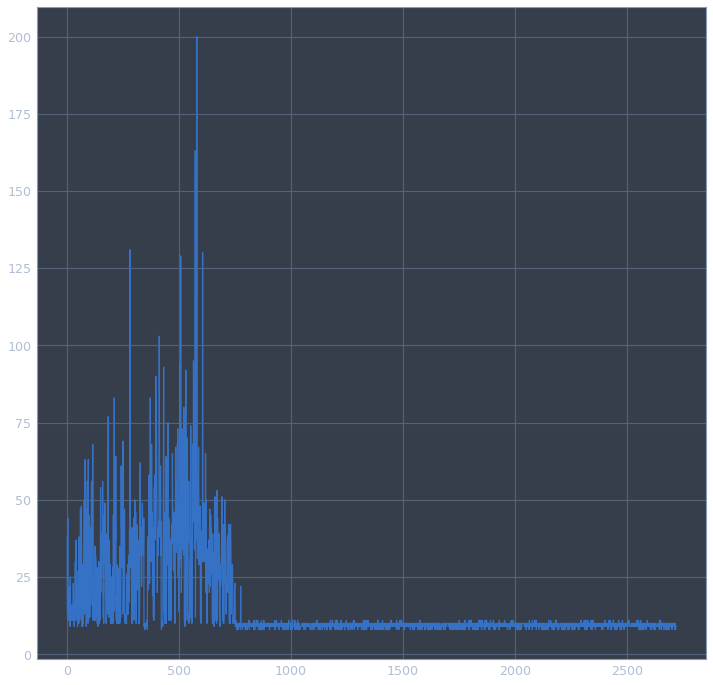

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt


glob_rewards_0 = global_rewards
plt.figure(figsize=(12, 12))
plt.plot(global_rewards)
plt.show()

In [27]:
policy_value_approximator.save_weights('model_weights/trained_policy_actor_critic')

In [28]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),
                           directory="videos_ac", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

In [30]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos_ac/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices